In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/tiurin/projects/ExampleProject/Temp/eye_quality/')

In [3]:
#|export
DATASET_PATH = "/home/tiurin/projects/ExampleProject/Temp"

In [4]:
#|export
from torch.utils.data import Dataset, Subset
import torch
import torchvision
import numpy as np

In [205]:
#|export
import os, glob
import random

class EyeQDataset(Dataset):

    def __init__(self, dataset_path, transform=None):
        self.transform = transform
        self.data = []
        random.seed(42)
        if not isinstance(dataset_path, list):
            dataset_path = [dataset_path]
        for p in dataset_path:
            for i in range(3):
                class_i = [(2-i, im) for im in glob.glob(os.path.join(p, str(i), '*.png'))]
                self.data.extend(class_i)

    def __len__(self):
        return len(self.data)

    def get_labels(self):
        return [i[0] for i in self.data]

    def __getitem__(self, idx):
        quality_class, image_path = self.data[idx]
        sample = torchvision.io.read_image(image_path).to(torch.float32)
        sample /= 255.0

        if self.transform:
            sample = self.transform(sample)

        return quality_class, sample

In [206]:
#|export

def get_padding(image, height, width):
    max_w = width 
    max_h = height
    
    imsize = (image.size(1), image.size(2))
    h_padding = (max_w - imsize[0]) / 2
    v_padding = (max_h - imsize[1]) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
    
    return padding

In [207]:
#|export
import random
def zoom_augmentation(tensor):
    width = tensor.size(dim=2)
    height = tensor.size(dim=1)
    scale = random.uniform(0.8, 1)
    width_n = int(width*scale)
    height_n = int(height*scale)
    tensor = torchvision.transforms.functional.resize(tensor, (height_n, width_n))
    padding = get_padding(tensor, width, height)
    tensor = torchvision.transforms.functional.pad(tensor, padding)
    return tensor

In [208]:
#|export
def get_dataset(train_percent = 0.9, rotation_transform=True):
    
    transforms = []
    
    if rotation_transform:
        transforms.append(torchvision.transforms.RandomRotation(degrees=(0, 360)))
        
    transforms.append(torchvision.transforms.RandomHorizontalFlip(p=0.5))
    transforms.append(torchvision.transforms.RandomVerticalFlip(p=0.5))
    transforms.append(zoom_augmentation)
    transforms.append(torchvision.transforms.Resize((400,400)))
    transforms.append(torchvision.transforms.Normalize((0.456), (0.224)))
    
    transform = torchvision.transforms.Compose(transforms)
    
    dataset_paths = [os.path.join(DATASET_PATH, 'processed'),os.path.join(DATASET_PATH, 'processed_test')]
    
    dataset = EyeQDataset(dataset_paths, transform=transform)
    lbls = np.asarray(dataset.get_labels())
    
    idx_train = []
    idx_val = []
    
    np.random.seed(42)
    for i in range(3):
        idx = np.where(lbls==i)[0]
        np.random.shuffle(idx)
        train_size = int(len(idx)*train_percent)
        val_size = len(idx)-train_size
        idx_train.extend(idx[:train_size].tolist())
        idx_val.extend(idx[train_size:].tolist())
    
    P = torch.bincount(torch.Tensor(lbls).to(torch.long))/len(dataset)
    class_weights = torch.sqrt(1/P)
    
    train_set = Subset(dataset, idx_train)
    val_set = Subset(dataset, idx_val)
    
    return train_set, val_set, class_weights

In [209]:
#|export
def inverse_transform(tensor):
    invTrans = torchvision.transforms.Compose(
        [torchvision.transforms.Normalize(mean = [ 0.],std = [ 1/0.224]),
        torchvision.transforms.Normalize(mean = [-0.456],std = [1.])])
    return invTrans(tensor)

In [1]:
#|export
def prepare_for_vis(tensor):
    tensor = inverse_transform(tensor)
    tensor = tensor.detach().numpy().transpose(1,2,0)
    return tensor

In [211]:
import matplotlib.pyplot as plt

In [212]:
ts, vs, cw = get_dataset(train_percent=0.9, rotation_transform=False)

In [213]:
ts[0][0]

0

In [214]:
img = ts[0][1]

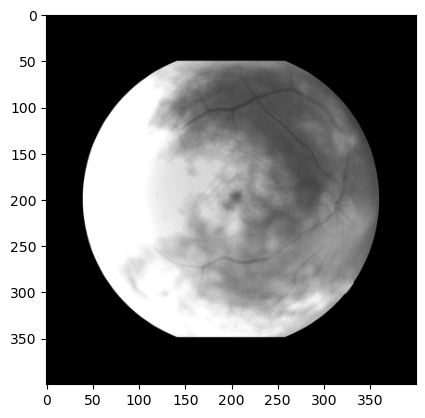

In [215]:
plt.imshow(prepare_for_vis(img),cmap='gray')

In [2]:
#|default_exp dataset_utils
#|hide
nbpath = '/home/tiurin/projects/ExampleProject/Temp/code/nbs/dataset_utils.ipynb'
import nbdev; nbdev.nbdev_export(nbpath)